In [1]:
import matplotlib.pyplot as plt
import json
from functools import partial

In [2]:
import torch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

/Users/lliu/code/geo-deep-forecast/.geo-deep-env3.8-v5/lib/python3.8/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [5]:
from pts.model.deepar import DeepAREstimator
from pts.modules import ZeroInflatedNegativeBinomialOutput
from pts import Trainer

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [6]:
dataset = get_dataset("pts_m5", regenerate=False)

AssertionError: pts_m5 is not present, please choose one from odict_keys(['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']).

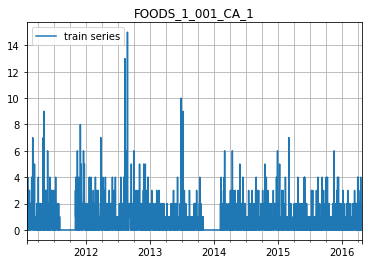

In [9]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.title(entry['item_id'])
plt.show()

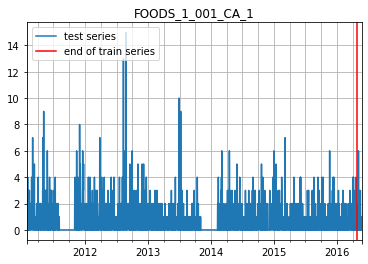

In [10]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.title(entry['item_id'])
plt.show()

In [11]:
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Recommended prediction horizon: 28
Frequency of the time series: D


In [17]:
estimator = DeepAREstimator(
    distr_output=ZeroInflatedNegativeBinomialOutput(),
    cell_type='GRU',
    input_size=72,
    num_cells=64,
    num_layers=3,
    dropout_rate=0.2,
    use_feat_dynamic_real=True,
    use_feat_static_cat=True,
    cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
    embedding_dimension = [4, 4, 4, 4, 16],
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    freq=dataset.metadata.freq,
    scaling=True,
    trainer=Trainer(device=device,
                    epochs=50,
                    learning_rate=1e-3,
                    num_batches_per_epoch=120,
                    batch_size=256,
                    num_workers=8,
                   )
)

In [18]:
predictor = estimator.train(dataset.train)

119it [02:44,  1.39s/it, avg_epoch_loss=1.18, epoch=0]


In [21]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [22]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [25]:
evaluator = Evaluator(num_workers=0)
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 30490/30490 [03:42<00:00, 137.06it/s]


In [26]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 6.058231599133125,
    "abs_error": 898994.0,
    "abs_target_sum": 1231764.0,
    "abs_target_mean": 1.4428196598416343,
    "seasonal_error": 1.1272178349378457,
    "MASE": 0.9187582800838673,
    "MAPE": 0.3138891162975238,
    "sMAPE": 0.721700212685564,
    "OWA": NaN,
    "MSIS": 8.565326751268298,
    "QuantileLoss[0.1]": 241247.00000000003,
    "Coverage[0.1]": 0.002498477252494963,
    "QuantileLoss[0.2]": 459438.39999999997,
    "Coverage[0.2]": 0.011113714098299208,
    "QuantileLoss[0.3]": 646149.0,
    "Coverage[0.3]": 0.029292976619969074,
    "QuantileLoss[0.4]": 795096.4,
    "Coverage[0.4]": 0.06370121351262709,
    "QuantileLoss[0.5]": 898994.0,
    "Coverage[0.5]": 0.11985428477721033,
    "QuantileLoss[0.6]": 954627.2,
    "Coverage[0.6]": 0.19450873822799047,
    "QuantileLoss[0.7]": 939651.9999999999,
    "Coverage[0.7]": 0.3110961439347796,
    "QuantileLoss[0.8]": 840218.8,
    "Coverage[0.8]": 0.4717834887316684,
    "QuantileLoss[0.9]": 618277.39

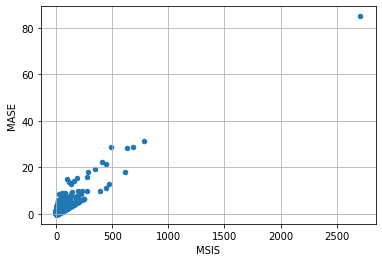

In [27]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()